<h1 style='text-align: center;'>DATA PREPARATION</h1>

### Import the Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from joblib import dump
from typing import Union, Callable, Tuple, List

### Complete-case Analysis

In [2]:
df = pd.read_excel("../data/UTI DATASET-LABELED.xlsx")
display(df)

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0.6,MALE,YELLOW,CLEAR,NEGATIVE,NEGATIVE,6.0,1.015,1-2,0-1,RARE,FEW,NONE SEEN,RARE,NEGATIVE
1433,42.0,MALE,YELLOW,CLEAR,NEGATIVE,NEGATIVE,6.5,1.010,0-2,0-2,RARE,NONE SEEN,NONE SEEN,RARE,NEGATIVE
1434,47.0,FEMALE,DARK YELLOW,CLEAR,NEGATIVE,TRACE,6.0,1.030,2-4,0-2,MODERATE,MODERATE,NONE SEEN,RARE,NEGATIVE
1435,57.0,FEMALE,DARK YELLOW,CLEAR,NEGATIVE,TRACE,5.0,1.030,0-2,0-2,PLENTY,PLENTY,NONE SEEN,FEW,NEGATIVE


In [3]:
df.isna().sum()

Age                 1
Gender              0
Color               1
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.isna().sum()

Age                 0
Gender              0
Color               0
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

### Feature Encoding

In [6]:
def custom_sort(value: str) -> Union[int, float]:
    """
        Sorting string range values, and with greater than or less than, e.g, 80-90, <50, 100> or LOADED

        Parameters
        ------------
        value : str
            the string data that needs to be sorted

        Returns
        ------------
        if ```value``` contains '>', return an integer without the sign.
        elif ```value``` is equal to LOADED or TNTC (Too Numerous to Count), return the highest floating point number.
        elif ```value``` is a range e.g 10-15, calculate the midpoint of the range by splitting the range into two number and return the midpoint
    """
    
    if value.__contains__(">"):
        return int(value.replace(">", ""))
    elif value.isalpha():
        return int(np.finfo(np.float64).max)
    else:
        start, end = map(int, value.split('-'))
        return start + (end - start) / 2

def encode_features(
        dataframe_: pandas.core.frame.DataFrame, 
        ordinal_features: Union[list, tuple, set], 
        nominal_features: Union[list, tuple, set]
    ) -> pandas.core.frame.DataFrame:
    """
        Encodes the nominal and ordinal features of the dataset using map function for ordinal and One-Hot Encoding for nominal.

        Parameters
        ------------
        dataframe_ : pandas.core.frame.DataFrame
            the dataframe that contains the nominal and orginal features

        ordinal_features : list, tuple, set
            a list of strings that corresponds to the column name of the ordinal features

        nominal_features : list, tuple, set
            a list of strings that corresponds to the column name of the nominal features

        Returns
        ------------
        dataframe_ : pandas.core.frame.DataFrame
            returns the preprocessed dataframe with all the ordinal and nominal features encoded
    """
    
    MAPPING_REFERENCE = {"ABSENCE_REFERENCE": {"NONE SEEN":0, 
                                               "RARE":1,
                                               "FEW":2,
                                               "OCCASIONAL":3,
                                               "MODERATE":4,
                                               "LOADED":5,
                                               "PLENTY":6},
                        
                        "Color": {"LIGHT YELLOW":0,
                                  "STRAW":1,
                                  "AMBER":2,
                                  "BROWN":3,
                                  "DARK YELLOW":4,
                                  "YELLOW":5,
                                  "REDDISH YELLOW":6,
                                  "REDDISH":7,
                                  "LIGHT RED":8,
                                  "RED":9},
                         
                        "Transparency": {"CLEAR":0,
                                         "SLIGHTLY HAZY":1,
                                         "HAZY":2,
                                         "CLOUDY":3,
                                         "TURBID":4},

                        "Protein_and_Glucose": {"NEGATIVE":0,
                                                "TRACE":1,
                                                "1+":2,
                                                "2+":3,
                                                "3+":4,
                                                "4+":5}}
    
    SORTED_RANGE_VALUES = np.array(sorted(set(df["RBC"]) | set(df["WBC"]), key=custom_sort))
    
    for ordinal in ordinal_features:
        if ordinal in ["Epithelial Cells", "Mucous Threads", "Amorphous Urates", "Bacteria"]:
            dataframe_[ordinal] = dataframe_[ordinal].map(MAPPING_REFERENCE["ABSENCE_REFERENCE"])

        elif ordinal in ["Protein", "Glucose"]:
            dataframe_[ordinal] = dataframe_[ordinal].map(MAPPING_REFERENCE["Protein_and_Glucose"])

        elif ordinal in ["WBC", "RBC"]:
            NUM_OF_SPLITS = 13
            SPLITTED_ARRAY = np.hsplit(np.array(SORTED_RANGE_VALUES), NUM_OF_SPLITS)

            LIST_OF_BIN = [*SPLITTED_ARRAY]
        
            def mapping_function(value: str) -> int:
                MAP_ = {tuple(bin_):idx for idx, bin_ in enumerate(LIST_OF_BIN)}

                for key, reference in MAP_.items():
                    if value in key:
                        return reference

            dataframe_[ordinal] = dataframe_[ordinal].map(mapping_function)
        else:
            dataframe_[ordinal] = dataframe_[ordinal].map(MAPPING_REFERENCE[ordinal])
            
    for nominal in nominal_features:
        dataframe_ = pd.concat([dataframe_, pd.get_dummies(dataframe_[nominal])["FEMALE"]], axis=1).drop(nominal, axis=1)
        
    return dataframe_

df = encode_features(df, 
                    ordinal_features=["Transparency", 
                                      "Epithelial Cells", 
                                      "Mucous Threads", 
                                      "Amorphous Urates", 
                                      "Bacteria",
                                      "Color",
                                      "Protein",
                                      "Glucose",
                                      "WBC",
                                      "RBC"],

                    nominal_features=["Gender"])

df

,Age,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis,FEMALE
0,76.0,0,0,0,0,5.0,1.010,0,0,3,1,0,3,NEGATIVE,True
1,9.0,4,1,0,2,5.0,1.030,0,0,1,2,2,4,NEGATIVE,False
2,12.0,0,1,0,1,5.0,1.030,0,0,1,2,4,1,NEGATIVE,False
3,77.0,3,3,0,2,6.0,1.020,3,12,1,1,0,2,NEGATIVE,False
4,29.0,5,2,0,1,6.0,1.025,1,0,1,1,0,2,NEGATIVE,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0.6,5,0,0,0,6.0,1.015,0,0,1,2,0,1,NEGATIVE,False
1433,42.0,5,0,0,0,6.5,1.010,0,0,1,0,0,1,NEGATIVE,False
1434,47.0,4,0,0,1,6.0,1.030,1,0,4,4,0,1,NEGATIVE,True
1435,57.0,4,0,0,1,5.0,1.030,0,0,6,6,0,2,NEGATIVE,True


### Performance Baseline (Before Resampling)

,0
NEGATIVE,1354
POSITIVE,81


1.35 * Proportion Chance Criterion: 120.61984241644309


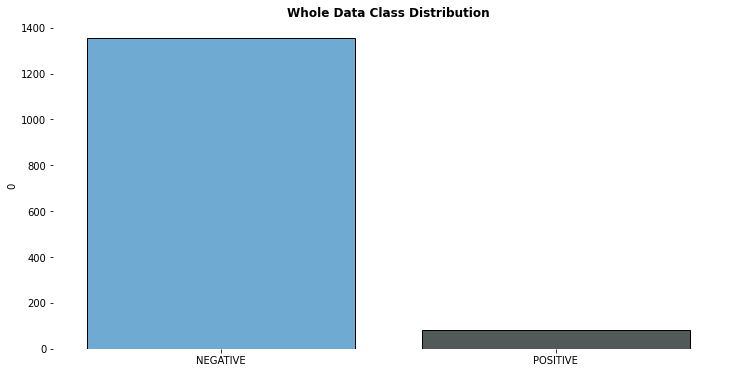

In [7]:
def performance_baseline(dataframe_: pandas.core.frame.DataFrame, plot_title: str, target_name: str = False, PCC: bool = False, weight: int = 1.35) -> None:
    """
        Calculates the performance baseline (weight multiplied by PCC or Proportion Chance Criterion) and plots the distribution of the target.

        Parameters
        ------------
        dataframe_ : pandas.core.frame.DataFrame
              the dataframe that contains the categorical features to encode
        plot_title : str
              the title of the plot
        target_name : str
              the name of the target to plot
        PCC : bool; default = False
              if True, calculates the PCC and prints out the results, if False, it will just plot the distribution
        weight : float; default = 1.35
                the specific weight multiplied by PCC

        Returns
        ------------
        None
    """
    if not target_name:
        state_counts = Counter(dataframe_)
        df_state = pd.DataFrame.from_dict(state_counts, orient="index")
    else:
        state_counts = Counter(dataframe_[target_name])
        df_state = pd.DataFrame.from_dict(state_counts, orient="index")
    

    _, axs = plt.subplots(figsize=(12, 6))

    for spine in ["top", "bottom", "left", "right"]:
        axs.spines[spine].set_visible(False)

    sns.barplot(x=df_state.index, y=df_state[0], palette = ["#5DADE2", "#515A5A"], ec="k")
    plt.title(plot_title, fontweight = "bold")

    if PCC:
        NUM = (df_state[0]/df_state[0].sum())**2

        display(df_state)
        print(f"{weight} * Proportion Chance Criterion: {weight*100*NUM.sum()}")

performance_baseline(df, plot_title="Whole Data Class Distribution", target_name="Diagnosis", PCC = True)

### Data Splitting, Oversampling & Feature Scaling

In [8]:

def oversample(X: pandas.core.frame.DataFrame, y: pandas.core.series.Series) -> Union[pandas.core.frame.DataFrame, pandas.core.series.Series]:
    """
        oversamples ```X``` and ```y``` using SMOTE resampling algorithm, it also encodes the target variable

        Parameters
        ------------
        X : pandas.core.frame.DataFrame
            a pandas dataframe that contains all the features data

        y : pandas.core.series.Series
            a pandas series that contains the target or dependent variable

        Returns
        ------------
        X : pandas.core.frame.DataFrame
            a pandas dataframe that contains all the features and synthetic data

        y : pandas.core.series.Series
            a pandas series that contains the target or dependent variable and synthetic data
    """
    
    OVERSAMPLE = SMOTE(random_state=42)

    def smote_wrapper(
            func: Callable[[pandas.core.frame.DataFrame, pandas.core.series.Series],
                            Tuple[pandas.core.frame.DataFrame, pandas.core.series.Series]]
        ) -> Union[pandas.core.frame.DataFrame, pandas.core.series.Series]:
        
        def inner(*args):
            X, y = args
            ENCODED_Y = y.map({"NEGATIVE": 0, "POSITIVE": 1})
            return func(X, ENCODED_Y)
        return inner


    ENCODE_AND_OVERSAMPLE = smote_wrapper(OVERSAMPLE.fit_resample)
    X, y = ENCODE_AND_OVERSAMPLE(X, y)

    X = X.astype({"Age": int})

    return X, y

def normalize_splits(
        X: pandas.core.frame.DataFrame, 
        y: pandas.core.series.Series, 
        test_size_: float, 
        random_state_: int, 
        continuous_features: list, 
        categorical_features: list
    ) -> Union[sklearn.preprocessing._data.MinMaxScaler,
               Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame, pandas.core.series.Series, pandas.core.series.Series],
               List[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame, pandas.core.series.Series, pandas.core.series.Series]]:
    """
        it normalizes only the continous feature in the dataframe using MinMaxScaler.

        Parameters
        ------------
        X : pandas.core.frame.DataFrame
            a pandas dataframe that contains all the features

        y : pandas.core.series.Series
            a pandas series that contains the target or dependent variable

        test_size_ : float
            the test size for train_test_split

        random_state_ : int
            random state for train_test_split
            
        continuous_features : list
            a list of continous features (string) e.g ["feature1", "feature2"]

        categorical_features : list
            a list of categorical features (string) e.g ["feature1", "feature2"]

        Returns
        ------------
        scaler_ : sklearn.preprocessing._data.MinMaxScaler
            returns the training data scaler
            
        scaled_splits : tuple
            returns the dataframe with the X and y splitted and normalized

        unscaled_splits : list
            returns the dataframe with the X and y splitted and NOT normalized
    """

    SCALER_ = MinMaxScaler()

    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,
                                                        y,
                                                        test_size = test_size_,
                                                        random_state = random_state_,
                                                        stratify = y)
    
    X_TRAIN_OVERSAMPLED, Y_TRAIN_OVERSAMPLED = oversample(X_TRAIN, Y_TRAIN)

    SCALER_.fit(X_TRAIN_OVERSAMPLED[continuous_features])

    X_train_scaled = SCALER_.transform(X_TRAIN_OVERSAMPLED[continuous_features])
    X_train_scaled = pd.DataFrame(X_train_scaled, columns = continuous_features)

    X_train_scaled = pd.concat([X_train_scaled, X_TRAIN_OVERSAMPLED[categorical_features].reset_index(drop=True)], axis=1)

    X_test_scaled = SCALER_.transform(X_TEST[continuous_features])
    X_test_scaled = pd.DataFrame(X_test_scaled, columns = continuous_features)

    X_test_scaled = pd.concat([X_test_scaled, X_TEST[categorical_features].reset_index(drop=True)], axis=1)

    Y_TEST_ENCODED = Y_TEST.map({"NEGATIVE": 0, "POSITIVE": 1})

    SCALED_SPLITS = (X_train_scaled, X_test_scaled, Y_TRAIN_OVERSAMPLED, Y_TEST_ENCODED)
    UNSCALED_SPLITS = [X_TRAIN, X_TEST, Y_TRAIN_OVERSAMPLED, Y_TRAIN_OVERSAMPLED]
    
    return SCALER_, SCALED_SPLITS, UNSCALED_SPLITS

In [9]:

X = df[["Age", "Color", "Transparency", "pH", "Glucose", "Protein", "Specific Gravity",
        "WBC", "RBC", "Epithelial Cells", "Mucous Threads",
        "Amorphous Urates", "Bacteria", "FEMALE"]]

y = df["Diagnosis"]

TRAIN_SCALER, SCALED_SPLITS, UNSCALED_SPLITS = normalize_splits(X, 
                                                                y, 
                                                                test_size_= 0.3, 
                                                                random_state_= 42, 
                                                                continuous_features= ["Age", "Color", "Transparency",
                                                                                      "Glucose", "Protein", "pH", 
                                                                                      "Specific Gravity", "WBC",
                                                                                      "RBC", "Epithelial Cells", "Mucous Threads",
                                                                                      "Amorphous Urates", "Bacteria"],                                                        
                                                                categorical_features= ["FEMALE"])

### Performance Baseline (After Resampling)

,0
0,947
1,947


1.35 * Proportion Chance Criterion: 67.5


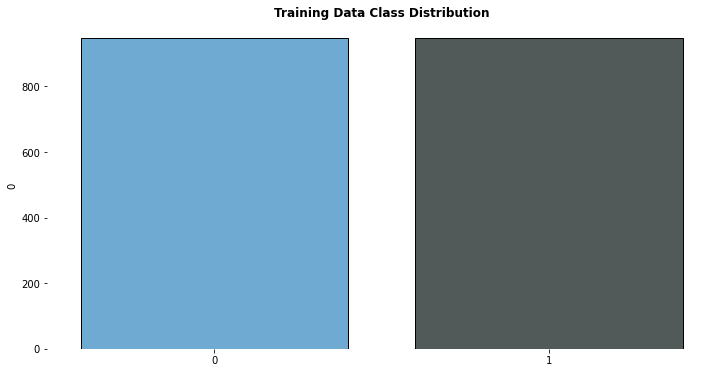

In [10]:
_, _, Y_TRAIN, _ = SCALED_SPLITS

performance_baseline(Y_TRAIN, plot_title="Training Data Class Distribution", PCC = True)

### Export the Data & Scaler

In [11]:
dump(TRAIN_SCALER, "../data/train_scaler.joblib")
dump(SCALED_SPLITS, "../data/preprocessed_data.joblib")
dump(UNSCALED_SPLITS, "../data/preprocessed_unscaled_data.joblib")

['../data/preprocessed_unscaled_data.joblib']